<a href="https://colab.research.google.com/github/An-Dongsun/Section4---Project/blob/main/AI_13_%EC%95%88%EB%8F%99%EC%84%A0_Section4__project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3가지 폐렴 분류 모델**

- 9208개 파일
    - 정상 → 3270개
    - 폐렴-세균 → 3001개
    - 폐렴-바이러스 → 1656개
    - COVID-19 → 1281개

데이터 출처 : [kaggle : 3 kinds of Pneumonia](https://www.kaggle.com/datasets/artyomkolas/3-kinds-of-pneumonia)

In [3]:
# 필요할 라이브러리 불러오기
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2


from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential

## 1. 데이터 불러오기

In [6]:
# 구글 드라이브와 연결한다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 시드를 고정한다.
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
# 이미지 파일들 불러오기
Dataset_directory = '/content/drive/MyDrive/Curated X-Ray Dataset'

train = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory, # 경로 넣어주면 된다.
        labels = "inferred", # 레이블은 디렉토리 구조에서 생성됨
        label_mode = "int", # 레이블이 정수로 인코딩됨을 의미
        class_names = {'COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral'}, #레이블은 이미지 파일 경로의 영숫자 순서에 따라 정렬되어야 한다
        color_mode = "rgb", # "grayscale", "rgb", "rgba" 중 하나
        batch_size = 32, # 데이터 배치의 크기입니다. 기본값: 32
        image_size = (256, 256), # 디스크에서 읽은 후 이미지 크기를 조정할 크기
        shuffle = True, # 데이터를 섞을지 여부. False로 설정하면 데이터를 영숫자 순서로 정렬
        seed = 42, # 셔플 및 변환을 위한 선택적 임의 시드
        validation_split = 0.1, # 0과 1 사이의 선택적 부동 소수점, 유효성 검사를 위해 데이터의 일부 나누기
        subset = 'training', # "training", "validation" → validation_split가 설정된 경우에만 사용
        interpolation = "bilinear", # 문자열, 이미지 크기를 조정할 때 사용되는 보간 방법, bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, 를 지원
        follow_links = False, # 심볼릭 링크가 가리키는 하위 디렉토리를 방문할지 여부
        crop_to_aspect_ratio = False, # True이면 가로 세로 비율 왜곡 없이 이미지 크기를 조정
)

test = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory, # 경로 넣어주면 된다.
        labels = "inferred", # 레이블은 디렉토리 구조에서 생성됨
        label_mode = "int", # 레이블이 정수로 인코딩됨을 의미
        class_names = {'COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral'}, #레이블은 이미지 파일 경로의 영숫자 순서에 따라 정렬되어야 한다
        color_mode = "rgb", # "grayscale", "rgb", "rgba" 중 하나
        batch_size = 32, # 데이터 배치의 크기입니다. 기본값: 32
        image_size = (256, 256), # 디스크에서 읽은 후 이미지 크기를 조정할 크기
        shuffle = True, # 데이터를 섞을지 여부. False로 설정하면 데이터를 영숫자 순서로 정렬
        seed = 42, # 셔플 및 변환을 위한 선택적 임의 시드
        validation_split = 0.1, # 0과 1 사이의 선택적 부동 소수점, 유효성 검사를 위해 데이터의 일부 나누기
        subset = 'validation', # "training", "validation" → validation_split가 설정된 경우에만 사용
        interpolation = "bilinear", # 문자열, 이미지 크기를 조정할 때 사용되는 보간 방법, bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, 를 지원
        follow_links = False, # 심볼릭 링크가 가리키는 하위 디렉토리를 방문할지 여부
        crop_to_aspect_ratio = False, # True이면 가로 세로 비율 왜곡 없이 이미지 크기를 조정
)

Found 9208 files belonging to 4 classes.
Using 8288 files for training.
Found 9208 files belonging to 4 classes.
Using 920 files for validation.


## 2. ResNet50 전이학습

In [ ]:
# weights = 'imagenet' → 이미지넷을 학습한 파라미터를 가져온다.
# include_top → 모델의 뒷쪽인 분류망을 가져올지 결정하는 파라미터
resnet = ResNet50(weights = 'imagenet', include_top = False)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
# ResNet50 레이어들의 파라미터를 학습하지 않도록 설정
for layer in resnet.layers:
    layer.trainable = False # True = 내가 집어 넣어준 데이터에 맞게 추가 학습한다.

In [ ]:
# 모델에 출력층을 생성해준다.
x = resnet.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x) # 출력층을 설계한다.
model = Model(resnet.input, predictions)

In [ ]:
# 모델의 전체적인 형태 확인해보기
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [ ]:
# 모델 컴파일
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# 간단하게 5Epoch만 모델을 학습한다.
model.fit(train, validation_data = test, epochs = 5)

Epoch 1/5
259/259 [==============================] - 1600s 6s/step - loss: 0.6135 - accuracy: 0.7899 - val_loss: 0.3864 - val_accuracy: 0.8467
Epoch 2/5
259/259 [==============================] - 94s 354ms/step - loss: 0.3687 - accuracy: 0.8415 - val_loss: 0.3980 - val_accuracy: 0.8380
Epoch 3/5
259/259 [==============================] - 97s 363ms/step - loss: 0.3332 - accuracy: 0.8570 - val_loss: 0.3569 - val_accuracy: 0.8565
Epoch 4/5
259/259 [==============================] - 90s 338ms/step - loss: 0.3153 - accuracy: 0.8641 - val_loss: 0.3201 - val_accuracy: 0.8630
Epoch 5/5
259/259 [==============================] - 86s 322ms/step - loss: 0.2987 - accuracy: 0.8721 - val_loss: 0.3514 - val_accuracy: 0.8598


In [ ]:
# 검증 데이터셋 사용해서 결과 보기
model.evaluate(test, verbose = 1)

29/29 [==============================] - 9s 226ms/step - loss: 0.3514 - accuracy: 0.8598


[0.3514041006565094, 0.8597826361656189]

## 3. Early Stopping(조기 종료) 적용

In [ ]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath = "resnet50_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 5 → 연속적으로 5번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results = model.fit(train,
                    batch_size = batch_size,
                    epochs = epochs_max,
                    verbose = 1, 
                    validation_data = test,
                    callbacks = [early_stop, save_best])

Epoch 1/50
259/259 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.7985
Epoch 1: val_loss improved from inf to 0.38575, saving model to resnet50_best.hdf5
259/259 [==============================] - 146s 322ms/step - loss: 0.5702 - accuracy: 0.7985 - val_loss: 0.3857 - val_accuracy: 0.8391
Epoch 2/50
259/259 [==============================] - ETA: 0s - loss: 0.3605 - accuracy: 0.8457
Epoch 2: val_loss did not improve from 0.38575
259/259 [==============================] - 83s 313ms/step - loss: 0.3605 - accuracy: 0.8457 - val_loss: 0.3968 - val_accuracy: 0.8511
Epoch 3/50
259/259 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.8527
Epoch 3: val_loss improved from 0.38575 to 0.32867, saving model to resnet50_best.hdf5
259/259 [==============================] - 84s 316ms/step - loss: 0.3374 - accuracy: 0.8527 - val_loss: 0.3287 - val_accuracy: 0.8663
Epoch 4/50
259/259 [==============================] - ETA: 0s - loss: 0.3110 - accuracy: 0.8

### 3-1) 학습된 모델을 이용하여 테스트

In [ ]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = model.evaluate(test, verbose = 1)

29/29 [==============================] - 9s 230ms/step - loss: 0.3721 - accuracy: 0.8457


### 3-2) best model을 이용한 테스트

In [ ]:
model.load_weights(checkpoint_filepath)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = model.evaluate(test, verbose = 1)

29/29 [==============================] - 9s 246ms/step - loss: 0.3287 - accuracy: 0.8663


## Restnet50 전이학습
  * 분류기 정교하게 구성

In [39]:
# weights = 'imagenet' → 이미지넷을 학습한 파라미터를 가져온다.
# include_top → 모델의 뒷쪽인 분류망을 가져올지 결정하는 파라미터
resnet = ResNet50(weights = 'imagenet', include_top = False)

In [40]:
# ResNet50 레이어들의 파라미터를 학습하지 않도록 설정
for layer in resnet.layers:
    layer.trainable = False # True = 내가 집어 넣어준 데이터에 맞게 추가 학습한다.

In [41]:
# 모델에 출력층을 생성해준다.
x = resnet.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x) # 출력층을 설계한다.
resnet_model2 = Model(resnet.input, predictions)

In [42]:
# 모델의 전체적인 형태 확인해보기
resnet_model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [43]:
# 모델 컴파일
resnet_model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [44]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath2 = "resnet_model2_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath2,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results = resnet_model2.fit(train,
                            batch_size = batch_size,
                            epochs = epochs_max,
                            verbose = 1, 
                            validation_data = test,
                            callbacks = [early_stop, save_best])

Epoch 1/50
259/259 [==============================] - ETA: 0s - loss: 0.5020 - accuracy: 0.7989
Epoch 1: val_loss improved from inf to 0.36182, saving model to resnet_model2_best.hdf5
259/259 [==============================] - 102s 374ms/step - loss: 0.5020 - accuracy: 0.7989 - val_loss: 0.3618 - val_accuracy: 0.8543
Epoch 2/50
259/259 [==============================] - ETA: 0s - loss: 0.3757 - accuracy: 0.8380
Epoch 2: val_loss did not improve from 0.36182
259/259 [==============================] - 91s 341ms/step - loss: 0.3757 - accuracy: 0.8380 - val_loss: 0.3681 - val_accuracy: 0.8565
Epoch 3/50
259/259 [==============================] - ETA: 0s - loss: 0.3567 - accuracy: 0.8425
Epoch 3: val_loss did not improve from 0.36182
259/259 [==============================] - 89s 336ms/step - loss: 0.3567 - accuracy: 0.8425 - val_loss: 0.3650 - val_accuracy: 0.8554
Epoch 4/50
259/259 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.8634
Epoch 4: val_loss did not impro

###4-1) 학습된 모델을 이용하여 테스트

In [45]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = resnet_model2.evaluate(test, verbose = 1)

29/29 [==============================] - 9s 228ms/step - loss: 0.4231 - accuracy: 0.8533


###4-2) resnet_model2_best을 이용한 테스트

In [46]:
resnet_model2.load_weights(checkpoint_filepath2)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = resnet_model2.evaluate(test, verbose = 1)

29/29 [==============================] - 9s 226ms/step - loss: 0.3175 - accuracy: 0.8652


##5. InceptionResNetV2 이용한 전이학습

### 5-1) 기본모델 가져와서 사용하기

In [14]:
inception_resnet = tf.keras.applications.InceptionResNetV2(
                              include_top = False,
                              weights = "imagenet",
                              input_tensor = None,
                              input_shape = (256, 256, 3),
                              )

In [15]:
# InceptionResNetV2 레이어들의 파라미터를 새로운 데이터에 맞게 학습하도록 설정
for layer in inception_resnet.layers:
    layer.trainable = True # True = 내가 집어 넣어준 데이터에 맞게 추가 학습한다.

In [16]:
# 모델에 출력층을 생성해준다.
x = inception_resnet.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x) # 출력층을 설계한다.
inception_resnet_model = Model(inception_resnet.input, predictions)

In [17]:
inception_resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 127, 127, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

In [18]:
# 모델 컴파일
inception_resnet_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [19]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath3 = "inception_resnet_model_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath3,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results3 = inception_resnet_model.fit(train,
                                      batch_size = batch_size,
                                      epochs = epochs_max,
                                      verbose = 1,
                                      validation_data = test,
                                      callbacks = [early_stop, save_best])

Epoch 1/50
259/259 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.7924
Epoch 1: val_loss improved from inf to 1.68521, saving model to inception_resnet_model_best.hdf5
259/259 [==============================] - 223s 774ms/step - loss: 0.5152 - accuracy: 0.7924 - val_loss: 1.6852 - val_accuracy: 0.6728
Epoch 2/50
259/259 [==============================] - ETA: 0s - loss: 0.3930 - accuracy: 0.8392
Epoch 2: val_loss improved from 1.68521 to 1.52801, saving model to inception_resnet_model_best.hdf5
259/259 [==============================] - 201s 763ms/step - loss: 0.3930 - accuracy: 0.8392 - val_loss: 1.5280 - val_accuracy: 0.8022
Epoch 3/50
259/259 [==============================] - ETA: 0s - loss: 0.3364 - accuracy: 0.8588
Epoch 3: val_loss improved from 1.52801 to 0.85621, saving model to inception_resnet_model_best.hdf5
259/259 [==============================] - 203s 770ms/step - loss: 0.3364 - accuracy: 0.8588 - val_loss: 0.8562 - val_accuracy: 0.8130
Epoch 4/

In [20]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = inception_resnet_model.evaluate(test, verbose = 1)

29/29 [==============================] - 10s 280ms/step - loss: 0.4688 - accuracy: 0.8717


In [21]:
inception_resnet_model.load_weights(checkpoint_filepath3)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = inception_resnet_model.evaluate(test, verbose = 1)

29/29 [==============================] - 10s 277ms/step - loss: 0.3073 - accuracy: 0.8880


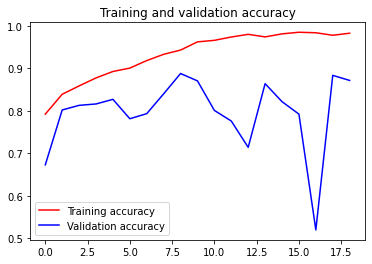

<Figure size 432x288 with 0 Axes>

In [47]:
acc = results3.history['accuracy']
val_acc = results3.history['val_accuracy']
loss = results3.history['loss']
val_loss = results3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

###5-2) 분류기 더 정교하게 쌓기